In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [53]:
df_trump = pd.read_csv("parsed_trump.csv")
df_biden = pd.read_csv("parsed_biden.csv")
df_biden.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:20,1.316529e+18,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,0.0,0.0,Twitter Web App,3.494182e+09,Flag Waver,Flag_Wavers,NaN,...,1536.0,Golden Valley Arizona,46.304036,-109.171431,NaN,United States of America,North America,Montana,MT,2020-10-21 00:00:01.035654566
2,2020-10-15 00:00:22,1.316529e+18,#censorship #HunterBiden #Biden #BidenEmails #...,1.0,0.0,Twitter Web App,1.032807e+18,the Gold State,theegoldstate,A Silicon Valley #independent #News #Media #St...,...,390.0,"California, USA",36.701463,-118.755997,NaN,United States of America,North America,California,CA,2020-10-21 00:00:02.071309132
3,2020-10-15 00:00:25,1.316529e+18,"In 2020, #NYPost is being #censorship #CENSORE...",0.0,0.0,Twitter for iPhone,1.994033e+07,Change Illinois | Biden will increase taxes by...,changeillinois,"Illinois, home of Lincoln and Reagan, used to ...",...,1397.0,"Chicago, Illinois",41.875562,-87.624421,Chicago,United States of America,North America,Illinois,IL,2020-10-21 00:00:03.106963698
4,2020-10-15 00:00:57,1.316529e+18,"FBI Allegedly Obtained Hunter Biden Computer, ...",0.0,0.0,Twitter for Android,9.607387e+17,RLCompton,NewfoundStudio,"""There are things known and there are things u...",...,266.0,"Kentucky, USA",37.572603,-85.155141,NaN,United States of America,North America,Kentucky,KY,2020-10-21 00:00:05.696100113


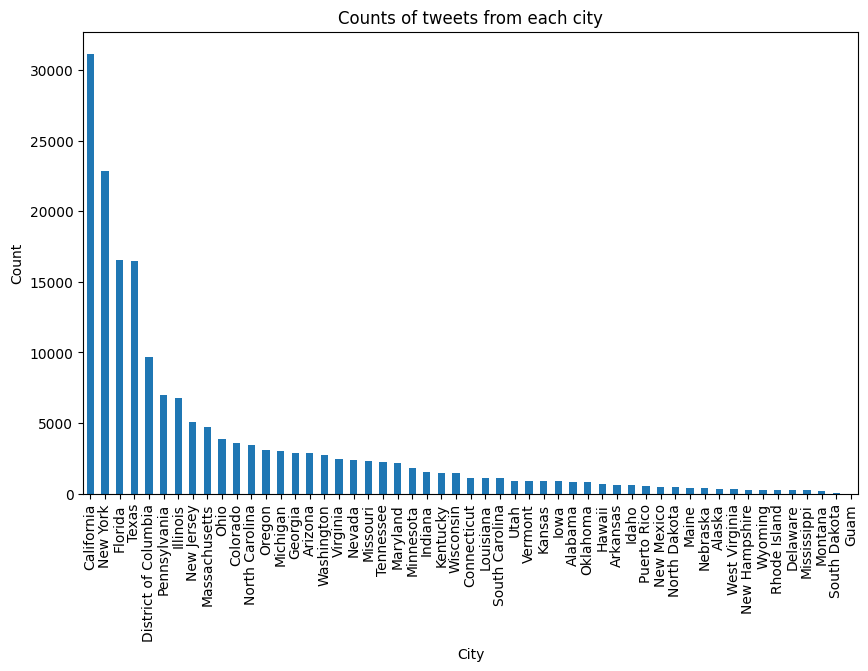

In [54]:
value_counts_trump = df_trump['state'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))  # Set the figure size (width, height)

# Plotting the counts
value_counts_trump.plot(kind='bar')
plt.title('Counts of tweets from each city')
plt.xlabel('City')
plt.ylabel('Count')
plt.show()

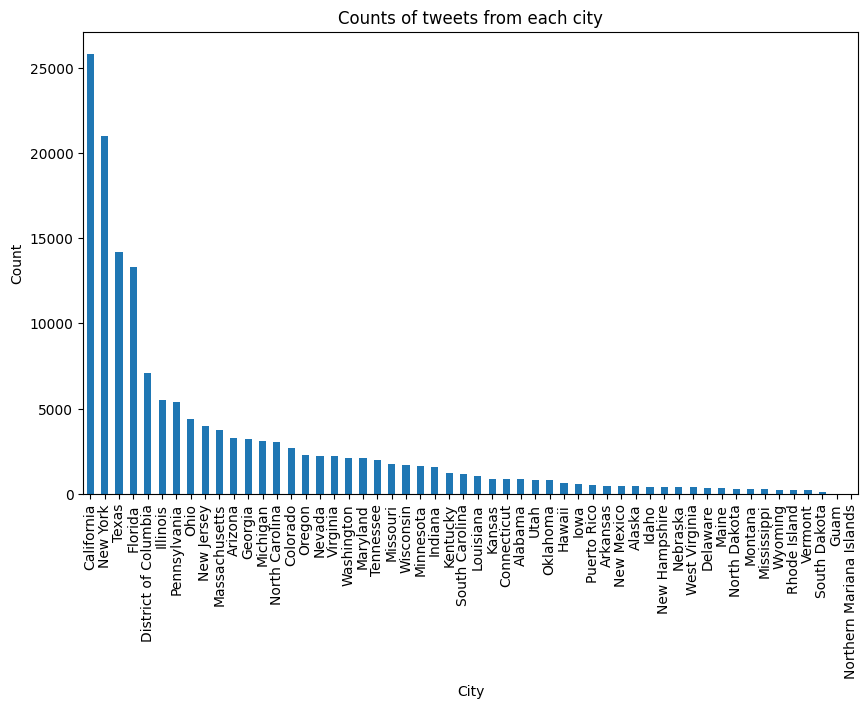

In [55]:
value_counts_biden = df_biden['state'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))  # Set the figure size (width, height)

# Plotting the counts
value_counts_biden.plot(kind='bar')
plt.title('Counts of tweets from each city')
plt.xlabel('City')
plt.ylabel('Count')
plt.show()

In [56]:
df_sentiment_biden = pd.read_csv("tweets_sentiment_analysis_biden.csv")
df_sentiment_biden.head()

# Assign a sentiment category based on the highest probability score
df_sentiment_biden['Dominant_Sentiment'] = df_sentiment_biden[['Negative', 'Neutral', 'Positive']].idxmax(axis=1)

# Group by 'state' and count the number of occurrences of each sentiment
sentiment_counts_per_state = df_sentiment_biden.groupby(['state', 'Dominant_Sentiment']).size().unstack(fill_value=0)

print(sentiment_counts_per_state)


Dominant_Sentiment    Negative  Neutral  Positive
state                                            
Alabama                    338      410       116
Alaska                     200      173        56
Arizona                   1274     1397       577
Arkansas                   185      196        88
California                8644    11376      5796
Colorado                   907     1227       553
Connecticut                316      377       185
Delaware                    93      136       102
District of Columbia      1592     4198      1265
Florida                   4474     6377      2427
Georgia                   1033     1511       642
Hawaii                     260      270       105
Idaho                      160      172        72
Illinois                  1996     2368      1136
Indiana                    603      651       298
Iowa                       225      223       124
Kansas                     321      362       205
Kentucky                   444      536       216


In [57]:
# Normalize the likes and retweets on a state-wise basis
def normalize_statewise(group):
    max_likes = group['likes'].max()
    max_retweets = group['retweet_count'].max()
    
    # Avoid division by zero in case max is 0
    group['State_Normalized_Likes'] = (group['likes'] / max_likes if max_likes != 0 else 0) * 100
    group['State_Normalized_Retweets'] = (group['retweet_count'] / max_retweets if max_retweets != 0 else 0) * 100
    
    return group

# Apply the normalization function to each state group and reset the index
df_normalized = df_sentiment_biden.groupby('state').apply(normalize_statewise).reset_index(drop=True)

# Define a function to calculate the weighted sentiment score
def calculate_weighted_score(row):
    # Check if the sentiment is positive or negative, and ignore neutral
    if row['Dominant_Sentiment'] == 'Positive':
        sentiment_score = 1
    elif row['Dominant_Sentiment'] == 'Negative':
        sentiment_score = -1
    else:
        # Return NaN for neutral to exclude it from the mean calculation later
        return np.nan
    
    # Calculate the weighted score using the normalized values
    weighted_score = sentiment_score * ((row['State_Normalized_Likes'] + row['State_Normalized_Retweets']) / 2)
    return weighted_score

# Apply the function to each row of the normalized dataframe
df_normalized['Weighted_Sentiment_Score'] = df_normalized.apply(calculate_weighted_score, axis=1)

# Now group by 'state' without setting it as an index
state_sentiment = df_normalized.groupby('state', as_index=False)['Weighted_Sentiment_Score'].mean()
# # Find the minimum non-zero values for 'likes' and 'retweets'
# min_likes = df_sentiment_biden[df_sentiment_biden['likes'] > 0]['likes'].min()
# min_retweets = df_sentiment_biden[df_sentiment_biden['retweet_count'] > 0]['retweet_count'].min()

# print(min_likes, min_retweets)


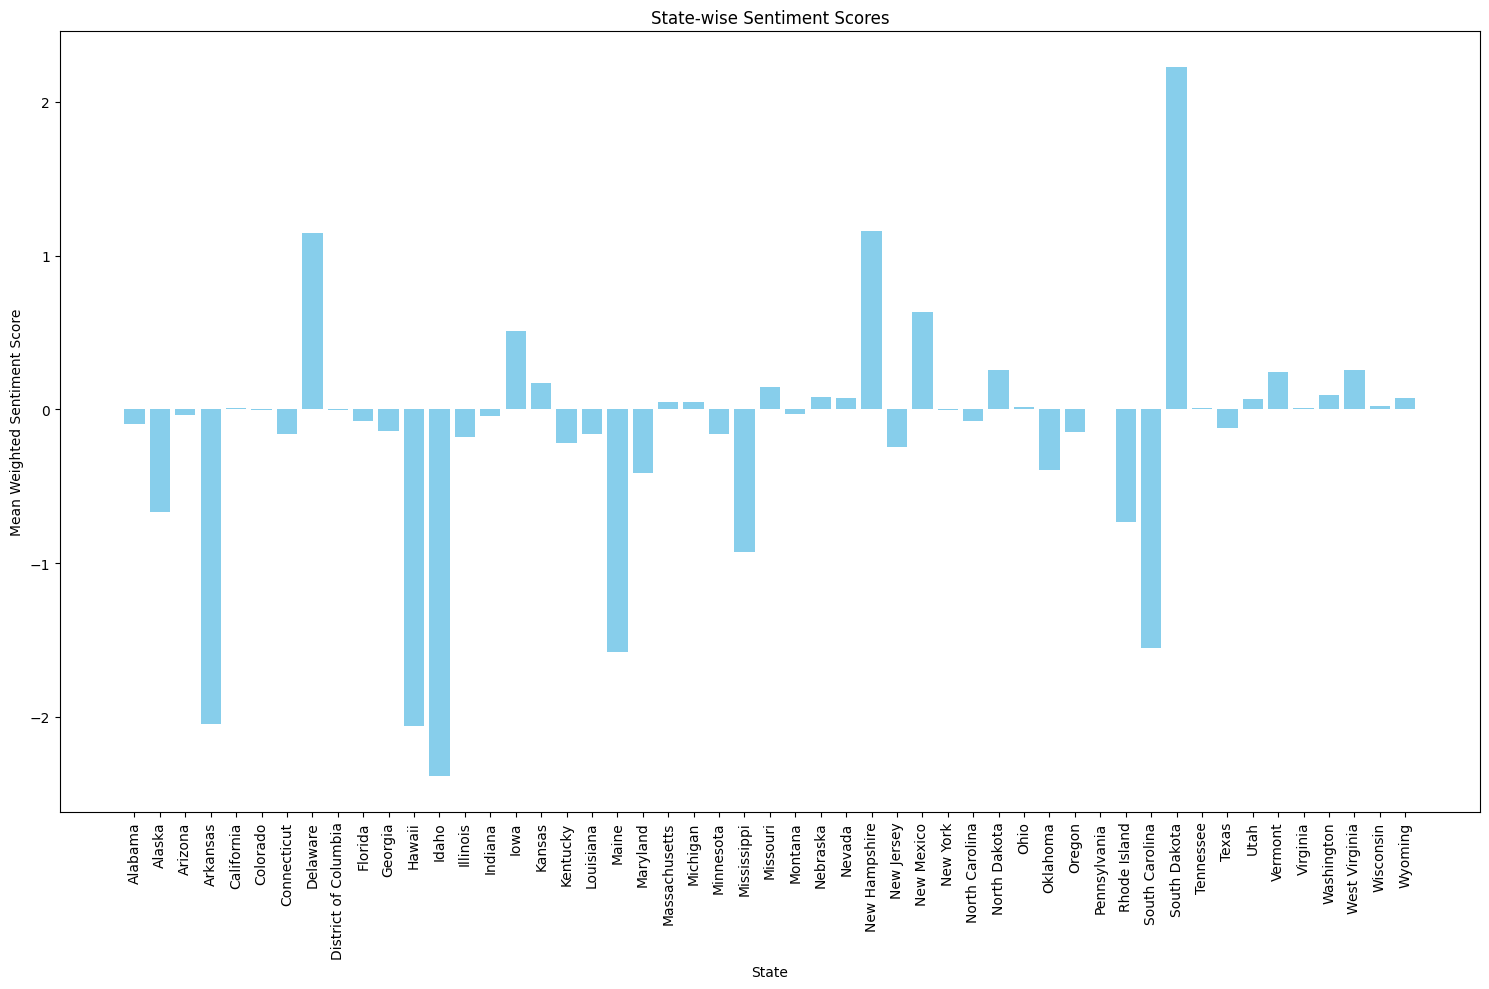

In [58]:
# Create a bar plot
plt.figure(figsize=(15, 10))  # Adjust the size as needed
plt.bar(state_sentiment['state'], state_sentiment['Weighted_Sentiment_Score'], color='skyblue')

# Add title and labels
plt.title('State-wise Sentiment Scores')
plt.xlabel('State')
plt.ylabel('Mean Weighted Sentiment Score')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()  # Adjust subplot params so that the subplot(s) fits in to the figure area
plt.show()

In [60]:
state_sentiment.to_csv("state_sentiment_scores_biden.csv", index=False)